In [1]:
####Rene 3_30_22

#### Matches LC-ICPMS data and LC-ESIMS data and assignes MF to peak.

#This file is for development. Main functions are embedded here.

# Import the os module
import os
import pandas as pd
import numpy as np

print(os.path.abspath(os.curdir))

# Change the current working directory
#os.chdir(os.path.dirname(os.getcwd()))
#print(os.path.abspath(os.curdir))

os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')



import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters


###### Set file folder and THERMO RAW file name here:
file_location = '/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS_Metallomics_Data/'
#file_name="rmb_161221_kansas_h2o_2"file_name="RMB_190828_TABPooled_12"
file_name="RMB_190828_TABPooled_12"


#Set peak detection threshold method
#MSParameters.mass_spectrum.threshold_method = 'relative_abundance'
#MSParameters.mass_spectrum.relative_abundance_threshold = 0.01

#MSParameters.mass_spectrum.threshold_method = 'auto'
#MSParameters.mass_spectrum.s2n_threshold = 4

MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 3

MSParameters.ms_peak.peak_min_prominence_percent = 0.1



#Parser for thermo RAW files. 
parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+file_name)


c:\Users\boiteaur\Desktop\CoreMS_metallomics\CoreMS\examples\metallomics


<class 'list'>
              EIC       Time
0        0.000000   0.003305
1        0.000000   0.017905
2        0.000000   0.050322
3        0.000000   0.086550
4        0.000000   0.117667
...           ...        ...
1585     0.000000  44.864632
1586     0.000000  44.892485
1587     0.000000  44.921785
1588     0.000000  44.949108
1589  2563.739258  44.979165

[1590 rows x 2 columns]


<AxesSubplot:xlabel='Time'>

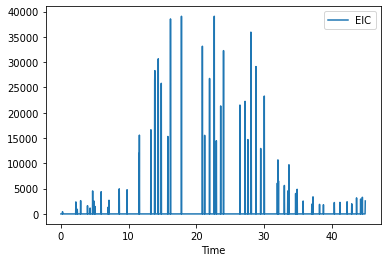

In [4]:
test=parser.get_eics(target_mzs=[381.05896],tic_data={},peak_detection=False,smooth=False)
#test=parser.get_eics(target_mzs=[381.05896])
print(type(test[0][381.05896].eic))


df=pd.DataFrame({'EIC':test[0][381.05896].eic,'Time':test[0][381.05896].time})
print(df)
df.plot.line(x='Time',y='EIC')

             63Cu  Time 63Cu
872   2591.022784   8.204017
873   2501.479299   8.213933
874   2412.851125   8.223850
875   2573.127661   8.233767
876   2636.242912   8.243683
..            ...        ...
968  11154.263840   9.156083
969  11153.437680   9.166000
970  10888.754590   9.175917
971  10915.409380   9.185833
972  11242.714170   9.195750

[101 rows x 2 columns]


<AxesSubplot:xlabel='Time 63Cu'>

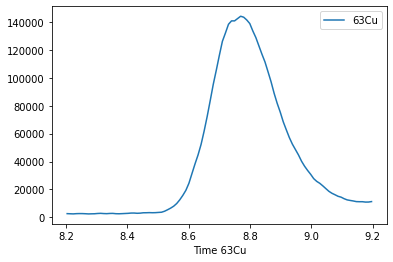

In [4]:
#Import LC-ICPMS data and plot it:

icpfile_location = "/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS_Metallomics_Data/161220_soils_hypercarb_3_kansas_qH2O.csv"
icp=pd.read_csv(icpfile_location)

#Pick out a time-slice of the ICPMS data that will be correlated w/ EIC data. 
peak=8.7
dt=0.5
timestart=peak-dt
timestop=peak+dt

#For this data set, need to apply offset to ICPMS data based on external calibration. In future, will use internal calibration based on b12).
offset=-27
element="63Cu"
etime="Time " + element

icpsubset = icp[[element,etime]]
icpsubset[etime] = (icpsubset[etime]+offset)/60

icpsubset=icpsubset[icpsubset[etime].between(timestart,timestop)]
print(icpsubset)

icpsubset.plot.line(x=etime,y=element)


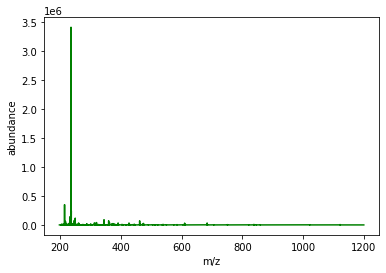

128


In [5]:
#Next, need to correlate every ESIMS mz detected across the time range with the metal intensity. 
#This section obtains EIC's for every m/z over the time range. 

#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
tic=parser.get_tic(ms_type='MS')[0]
tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})
scans=tic_df[tic_df.time.between(timestart,timestop)].scan.tolist()

#Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
AverageMS = parser.get_average_mass_spectrum_by_scanlist(scans)

AverageMS.plot_mz_domain_profile()
plt.show()

print(AverageMS.mz_exp.size)
### The correct assignment should be 381m/z

EICdic = {}
scanrange=scans

for mz in AverageMS.mz_exp:
    #EIC = pd.DataFrame(index=scanrange, columns=['Time', 'EIC'])
    mass=mz
    #print(mz)
    EIC=parser.get_eics(target_mzs=[mass],tic_data={},peak_detection=False,smooth=False)
    EICdic[mz]=EIC[0][mz]



In [6]:
###Interpolate LC-ICPMS data to obtain times matching ESI data
times=tic_df[tic_df.time.between(timestart,timestop)].time.tolist()

icpsubset2=icpsubset

for i in times:
    icpsubset2.loc[-1]=['NaN',i]
    icpsubset2 = icpsubset2.sort_index().reset_index(drop=True)

icpsubset2=icpsubset2.sort_values(by=etime)
icpsubset2=icpsubset2.astype(float)
icpsubset3=icpsubset2.interpolate()

icp_interp=pd.DataFrame()
for i in times:
    icp_interp=icp_interp.append(icpsubset3[icpsubset3[etime]==i])



In [7]:
# Calculate correlation between LC-ICPMS data ('icp_interp') and LC-ESIMS data ('EICdic'), save as dictionary

mscorr={}
EICcurr=pd.DataFrame(index=icp_interp[etime],columns=['EIC',element])


EICcurr=pd.DataFrame(index=icp_interp[etime],columns=['EIC',element])
EICcurr[element]=icp_interp[element].array

for mz in EICdic.keys():
    EIC=pd.DataFrame({'EIC':EICdic[mz].eic,'Time':EICdic[mz].time})
    EIC_sub=EIC[EIC['Time'].between(timestart,timestop)]
    #print(EIC_sub['EIC'])

    EICcurr['EIC']=EIC_sub['EIC'].values

    corvalue=EICcurr.corr(method='pearson')
    mscorr[mz]=corvalue.EIC[element]**2

matches=pd.DataFrame.from_dict(mscorr,orient='index',columns=['corr'])


'runworker'  38.00 ms


Loading molecular formula database: 168198it [00:09, 17726.35it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Cu": 1}, (de)protonated : 100%|██████████| 200/200 [00:00<00:00, 294.58it/s]


'run_molecular_formula'  10316.85 ms
67 assigned peaks and 61 unassigned peaks, total  = 52.34 %, relative abundance = 74.47 %, RMS error (best candidate) (ppm) = 0.625


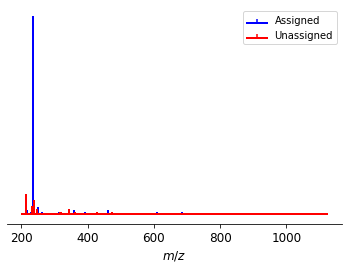

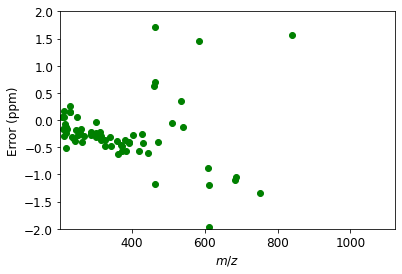

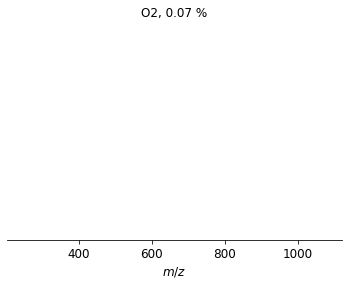

In [8]:
mass_spectrum=AverageMS

#Get molecular formula of average mass spectrum. 

mass_spectrum.molecular_search_settings.error_method = 'None'
mass_spectrum.molecular_search_settings.min_ppm_error = -2
mass_spectrum.molecular_search_settings.max_ppm_error = 2

mass_spectrum.molecular_search_settings.url_database = None
mass_spectrum.molecular_search_settings.min_dbe = 0
mass_spectrum.molecular_search_settings.max_dbe = 20

mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 50)
mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 100)
mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 20)
mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 4)
mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Cl'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Br'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['P'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Na'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Cu'] = (0,1)

mass_spectrum.molecular_search_settings.isProtonated = True
mass_spectrum.molecular_search_settings.isRadical = False
mass_spectrum.molecular_search_settings.isAdduct = False

# mass_spectrum.filter_by_max_resolving_power(15, 2)
SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned(report_error=True)
mass_spectrum.molecular_search_settings.score_method = "prob_score"
mass_spectrum.molecular_search_settings.output_score_method = "prob_score"

mass_spectrum_by_classes = HeteroatomsClassification(mass_spectrum, choose_molecular_formula=True)

mass_spectrum_by_classes.plot_ms_assigned_unassigned()
plt.show()
mass_spectrum_by_classes.plot_mz_error()
plt.show()
mass_spectrum_by_classes.plot_ms_class("O2")
plt.show()

#mass_spectrum.to_csv("Cu_matches")


#How do we return formula and assignment scores?

In [9]:
assignments=mass_spectrum.to_dataframe()
assignments=assignments.sort_values(by=['m/z'])

assignments.insert(4,'corr',matches['corr'].values)

threshold=0.8
results=assignments[assignments['corr']>threshold].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Cu'])
bestresults=results[results['Cu']==1]
print(bestresults)

           m/z      corr  Peak Height  Confidence Score  Molecular Formula  \
42  381.059032  0.913503  11189.19769          0.968769  C12 H19 O7 N3 Cu1   

     Cu  
42  1.0  
